# Topological Data Analysis (TDA)

TDA for detecting changes in time series.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gudhi as gd

import umap as um

plt.style.use("ggplot")
%matplotlib inline

from IPython.display import display_html
def display_side_by_side(*args):
    """
    Taken from https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side
    """
    html_str=''
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'), raw=True)

## Get raw data

In [3]:
df1 = pd.read_csv("../data/insead_2016_no_missing.csv.gz", index_col="timestamp",
                 parse_dates=["timestamp"], compression="gzip")
df2 = pd.read_csv("../data/insead_2018_no_missing.csv.gz", index_col="timestamp",
                 parse_dates=["timestamp"], compression="gzip")

In [4]:
features = [
"chwshdr",
"cwrhdr",
"cwshdr",
"cwsfhdr",
"loadsys",
"chwsfhdr", 
]

status_features = [
"ch1_status",
"ch2_status",
"ch3_status"    
]

target = ["totalkw"]

# Assign features and targets
y1 = df1.totalkw
y2 = df2.totalkw
X1 = df1[features]
X2 = df2[features]

## Get data divided into weeks

In [5]:
num_2006_weeks = X1.index.weekofyear.nunique()
num_2008_weeks = X2.index.weekofyear.nunique()
num_2006_days = X1.index.dayofyear.nunique()
num_2008_days = X2.index.dayofyear.nunique()
print("# 2006 days: {} # 2006 weeks: {}".format(num_2006_days, num_2006_weeks))
print("# 2008 days: {} # 2008 weeks: {}".format(num_2008_days, num_2008_weeks))
print("# 2006 examples: {} # 2008 examples: {}".format(len(X1), len(X2)))

# 2006 days: 58 # 2006 weeks: 9
# 2008 days: 37 # 2008 weeks: 7
# 2006 examples: 81623 # 2008 examples: 53147


In [18]:
y11.shape, X11.shape, X_keys[1]

((10065,), (10065, 6), 6)

In [6]:
# 2016 data
X_grouper = X1.groupby(df1.index.week)
X_keys = list(X_grouper.groups.keys())
y_grouper = y1.groupby(y1.index.week)

X11 = X_grouper.get_group(X_keys[0])
X12 = X_grouper.get_group(X_keys[1])
y11 = y_grouper.get_group(X_keys[0])
y12 = y_grouper.get_group(X_keys[1])

X_grouper = X2.groupby(df2.index.week)
X_keys = list(X_grouper.groups.keys())
y_grouper = y2.groupby(y2.index.week)

X21 = X_grouper.get_group(X_keys[2])
X22 = X_grouper.get_group(X_keys[3])
y21 = y_grouper.get_group(X_keys[2])
y22 = y_grouper.get_group(X_keys[3])

In [205]:
import umap as um

def group(X, labels):
        grouper = X.groupby(labels)
        keys = sorted(list(grouper.groups.keys()))
        return [grouper.get_group(k) for k in keys]

def fit_umap(X1, X2, y1, y2, n_weeks, **kwargs):
    """Fit UMAP reducer to weekly data"""        
        
    # Group data by week
    g_X1 = group(X1, X1.index.weekofyear)
    g_X2 = group(X2, X2.index.weekofyear)
    g_y1 = group(y1, y1.index.weekofyear)
    g_y2 = group(y2, y2.index.weekofyear)
    X = pd.concat(g_X1[:n_weeks] + g_X2[:n_weeks])
    
    reducer = um.UMAP(**kwargs)
    reducer.fit(X)

    return reducer

# Plot embeddings for each week
def plot_by_week(XX1, XX2, y1, y2, figsize=(12, 18), s=1, alpha=0.5, title=None, 
                 colorby="time",
                 cmap="magma"):
    
    assert colorby in ("time", "power")
    
    if colorby == "time":
        vmin = 0
        vmax = 24 * 60**2 + 2    
    elif colorby == "power":
        power = pd.concat((y1, y2))
        vmin = power.min()
        vmax = power.max() + 2
    
    
    week_labels1 = XX1.index.weekofyear
    week_labels2 = XX2.index.weekofyear
        
    X1_groups = group(XX1, week_labels1)
    X2_groups = group(XX2, week_labels2)
    y1_groups = group(y1, week_labels1)
    y2_groups = group(y2, week_labels2)
    
    t1_groups = group(time_of_day_seconds(y1.index), week_labels1)
    t2_groups = group(time_of_day_seconds(y2.index), week_labels2)
    
    n_weeks1 = week_labels1.nunique()
    n_weeks2 = week_labels2.nunique()
    
    fig, axes = plt.subplots(2, max(n_weeks1, n_weeks2), 
                             sharex=True, sharey=True, figsize=figsize)
    
    for ax, X, y, time, week in zip(axes[0], X1_groups, y1_groups, t1_groups, 
                                    np.sort(week_labels1.unique())):
        
        if colorby == "time":
            c = time
        elif colorby == "power":
            c = y.values
                    
        X = X.values
        ax.scatter(X[:, 0], X[:, 1], c=c, s=s, vmin=vmin, vmax=vmax,
                   alpha=alpha, cmap=cmap)
        ax.set_title("Week {}".format(week))
    
    for ax, X, y, time, week in zip(axes[1], X2_groups, y2_groups, t2_groups, 
                                    np.sort(week_labels2.unique())):  
        if colorby == "time":
            c = time
        elif colorby == "power":
            c = y.values
                    
        X = X.values
        im = ax.scatter(X[:, 0], X[:, 1], c=c, s=s, vmin=vmin, vmax=vmax,
                        alpha=alpha, cmap=cmap)
        ax.set_title("Week {}".format(week))    
            
    axes[0][0].set_ylabel("Year 2006", fontsize=14)    
    axes[1][0].set_ylabel("Year 2008", fontsize=14)

    cbar = fig.colorbar(im, ax=axes.ravel().tolist())
    cbar.set_ticks([vmin, (vmin + vmax) / 2, vmax])
    if colorby == "time":
        cbar.set_ticklabels(['00AM', '12PM', '12AM'])
    elif colorby == "power":
        cbar.set_ticklabels(["{:.2f} KW".format(p) for p in (vmin, (vmin + vmax) / 2, vmax)])
        
    if title is not None:
        fig.suptitle(title, fontsize=14)
#     fig.tight_layout(rect=[0, 0.03, 1, 0.95])
        
    return fig

def plot_days():
    pass

def time_of_day_seconds(time_index):
    return time_index.to_series().map(lambda x: x.hour * 3600 + x.minute * 60 + x.second)

In [69]:
reducer = fit_umap(X1, X2, y1, y2, 3, random_state=123, min_dist=0.01)

In [72]:
# Embed points
XX1 = reducer.transform(X1)
XX2 = reducer.transform(X2)
XX1 = pd.DataFrame(XX1, index=X1.index)
XX2 = pd.DataFrame(XX2, index=X2.index)

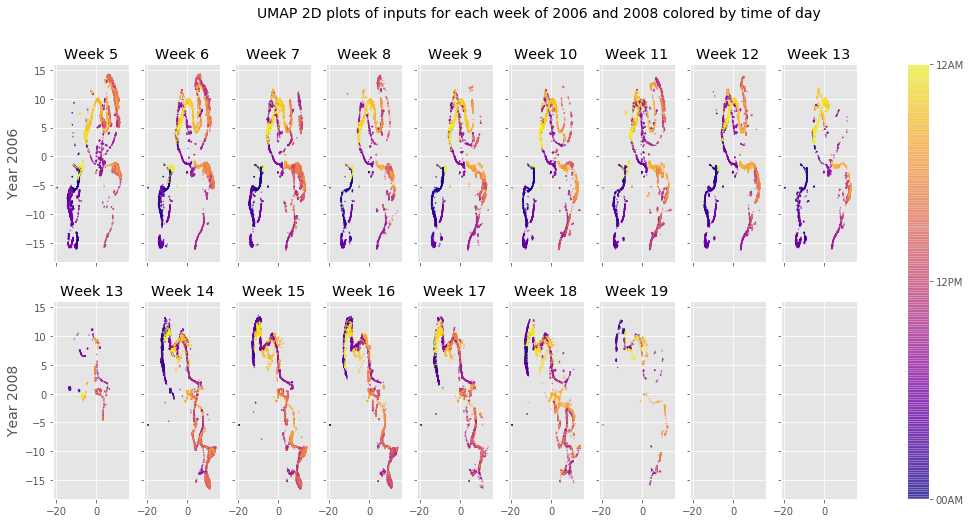

In [209]:
fig = plot_by_week(XX1, XX2, y1, y2, figsize=(18, 8), 
                   title="UMAP 2D plots of inputs for each week"\
                   " of 2006 and 2008 colored by time of day",
                   colorby="time", cmap="plasma");

In the above plots, color indicates time.

As a reminder, each $\mathbf{x}_t$ represents the observed quantities for [chwshdr, cwrhdr, cwshdr, cwsfhdr, loadsys, chwsfhdr] at time $t$.

The plots suggests the following
1. The observed inputs $\mathbf{x}_t$s from year 2006 overall are different from those from 2008.
2. In particular, the observations in 2006 night time (**near and after midnight**) are different from those in 2008. There seems to be some extra "activity" after midnight for 2006 that is not present in 2008.  
3. These readings vary throughout the day but are similar to those close in time. Note that from the 1 dimensional plots of the power we know the **output power**, $y_t$ are similar close in time, but these plots says that the **inputs** are also similar.
4. Note the brightest yellow mix with the darkest purple in some parts. This is because one is 12AM and the other is 00AM. In 2006, after 12AM. For 2006, midnight is a "cutoff" point when the system transition into a different state (bottom left purple region) that we do not see in 2008.

Next, we color these plots using the power instead of time.

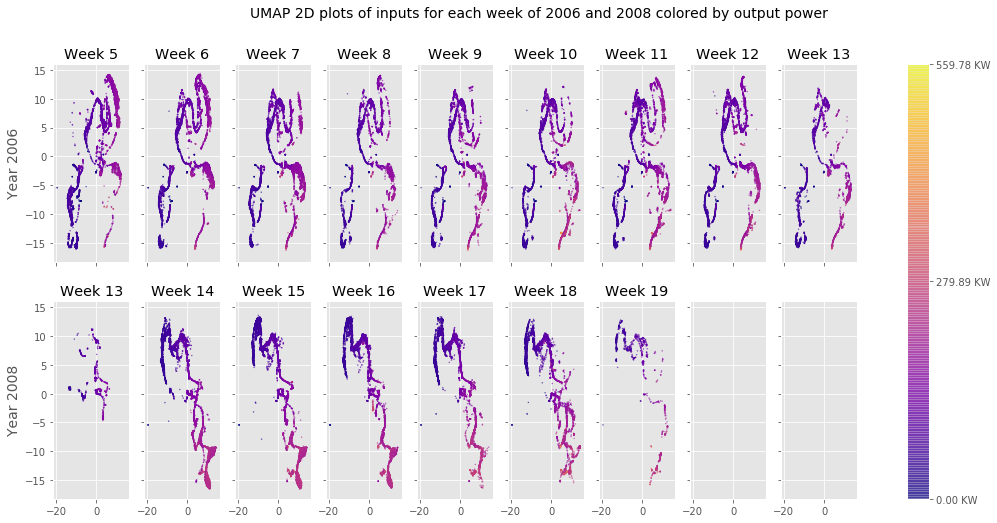

In [208]:
fig = plot_by_week(XX1, XX2, y1, y2, figsize=(18, 8), 
                   title="UMAP 2D plots of inputs for each week"\
                   " of 2006 and 2008 colored by output power",
                   colorby="power", cmap="plasma");

1. On average, peak output is ~300 KW with anomalies hitting up to 550+ KW. We know this from the 1 dimensional plots so this is nothing new.
2. But we also notice that the inputs that leads to the larger power (bottom and top right half) are different from those 


## Quantify these differences using TDA and MMD

In [ ]:
# Plot colorbar. Ensure all subplots uses same scale



In [ ]:
# Plot total power as color.



In [145]:
# Compute TDA metric on embedded points
# Compare day to day and week to week
# Plot distance matrix

import gudhi as gd



In [146]:
# TODO: Consider using R-TDA if gudhi does not give correct results



In [ ]:
# Compute MMD on embedded points



## Plot UMAP embeddings

In [58]:
X_train = np.vstack((X1, X2))
X_train.shape

(19911, 20)

In [59]:
reducer = umap.UMAP(n_neighbors=15, n_components=2, random_state=123)
reducer.fit(X_train)

/home/hongwei/anaconda3/envs/bca-env/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding 6 connected components using meta-embedding (experimental)
  n_components
/home/hongwei/anaconda3/envs/bca-env/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=123,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=False)

In [60]:
X1_red = reducer.transform(X1)
Y1_red = reducer.transform(Y1)

X2_red = reducer.transform(X2)
Y2_red = reducer.transform(Y2)

In [52]:
%matplotlib inline

In [69]:
df1.shape

(81623, 13)

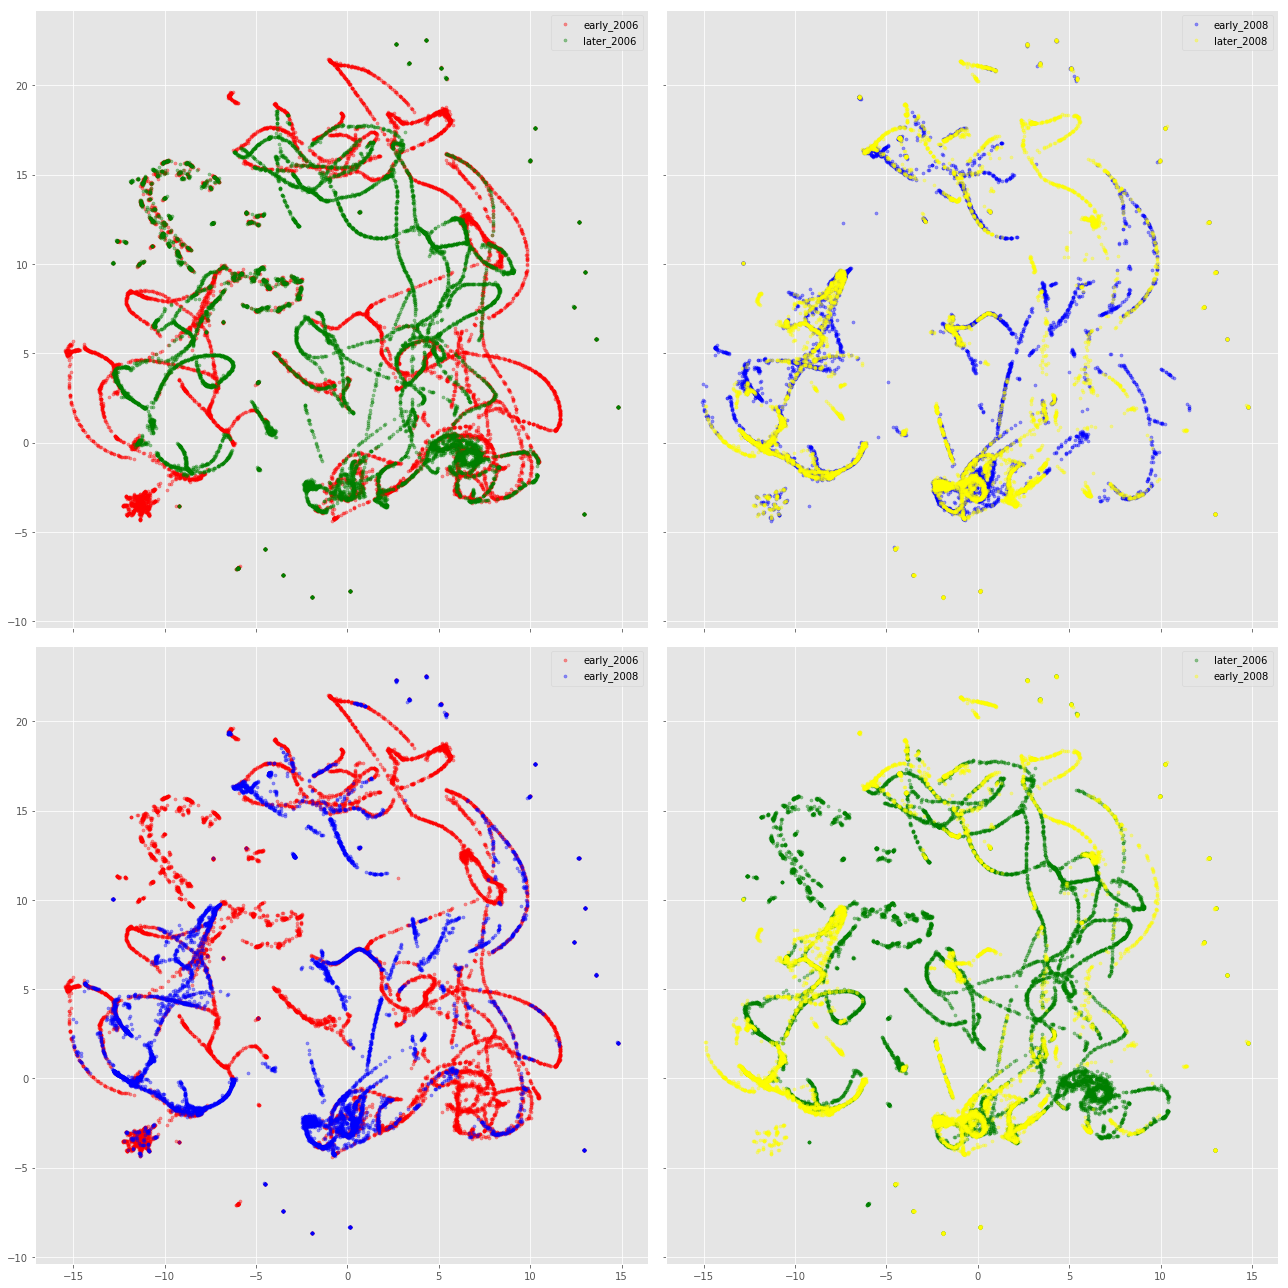

In [68]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(18, 18))

alpha = 0.4

axes[0, 0].scatter(X1_red[:, 0], X1_red[:, 1], color="red", alpha=alpha, s=10, label="early_2006")
axes[0, 0].scatter(X2_red[:, 0], X2_red[:, 1], color="green", alpha=alpha, s=10, label="later_2006")


axes[0, 1].scatter(Y1_red[:, 0], Y1_red[:, 1], color="blue", alpha=alpha, s=10, label="early_2008")
axes[0, 1].scatter(Y2_red[:, 0], Y2_red[:, 1], color="yellow", alpha=alpha, s=10, label="later_2008")

axes[1, 0].scatter(X1_red[:, 0], X1_red[:, 1], color="red", alpha=alpha, s=10, label="early_2006")
axes[1, 0].scatter(Y1_red[:, 0], Y1_red[:, 1], color="blue", alpha=alpha, s=10, label="early_2008")

axes[1, 1].scatter(X2_red[:, 0], X2_red[:, 1], color="green", alpha=alpha, s=10, label="later_2006")
axes[1, 1].scatter(Y2_red[:, 0], Y2_red[:, 1], color="yellow", alpha=alpha, s=10, label="early_2008")

for ax in axes.ravel():
    ax.legend()


# fig.legend()
fig.tight_layout()

<IPython.core.display.Javascript object>


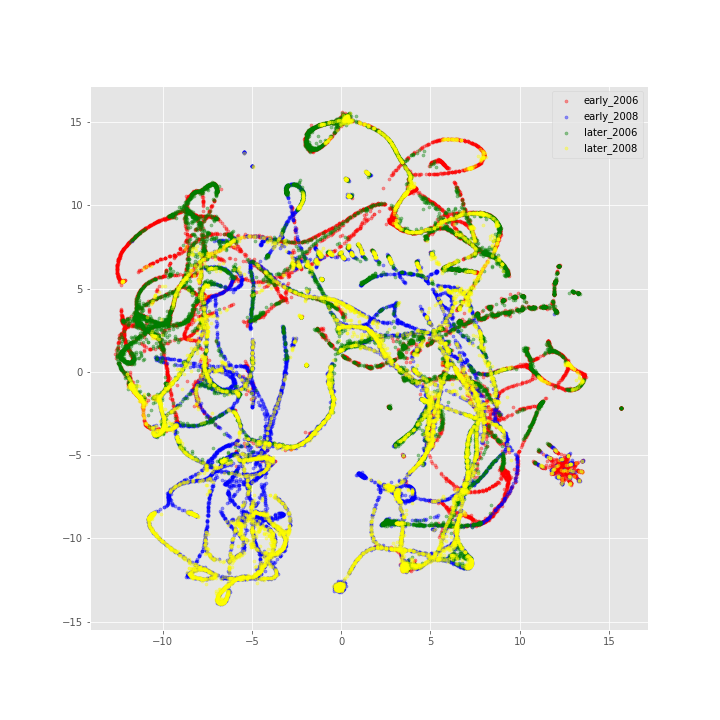

In [47]:
plt.figure(figsize=(10, 10))

alpha = 0.4

plt.scatter(X1_red[:, 0], X1_red[:, 1], color="red", alpha=alpha, s=10, label="early_2006")
# plt.scatter(Y1_red[:, 0], Y1_red[:, 1], color="blue", alpha=alpha, s=10, label="early_2008")

plt.scatter(X2_red[:, 0], X2_red[:, 1], color="green", alpha=alpha, s=10, label="later_2006")
# plt.scatter(Y2_red[:, 0], Y2_red[:, 1], color="yellow", alpha=alpha, s=10, label="later_2008")
plt.legend()

<IPython.core.display.Javascript object>


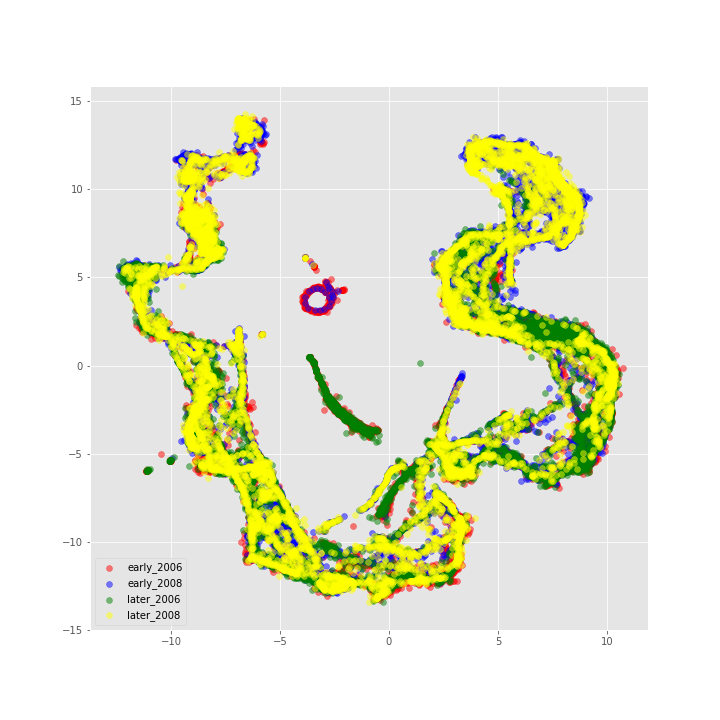

In [28]:
plt.figure(figsize=(10, 10))
plt.scatter(X1_red[:, 0], X1_red[:, 1], color="red", alpha=0.5, label="early_2006")
plt.scatter(Y1_red[:, 0], Y1_red[:, 1], color="blue", alpha=0.5, label="early_2008")

plt.scatter(X2_red[:, 0], X2_red[:, 1], color="green", alpha=0.5, label="later_2006")
plt.scatter(Y2_red[:, 0], Y2_red[:, 1], color="yellow", alpha=0.5, label="later_2008")
plt.legend()

## Plot sliding window embeddings

Plot 3D PCA embeddings of sliding window embeddings.

In [10]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

%matplotlib notebook
%matplotlib notebook

pca = PCA(n_components=3)

XX1 = pca.fit_transform(X1)
XX2 = pca.fit_transform(X2)

YY1 = pca.fit_transform(Y1)
YY2 = pca.fit_transform(Y2)

<IPython.core.display.Javascript object>


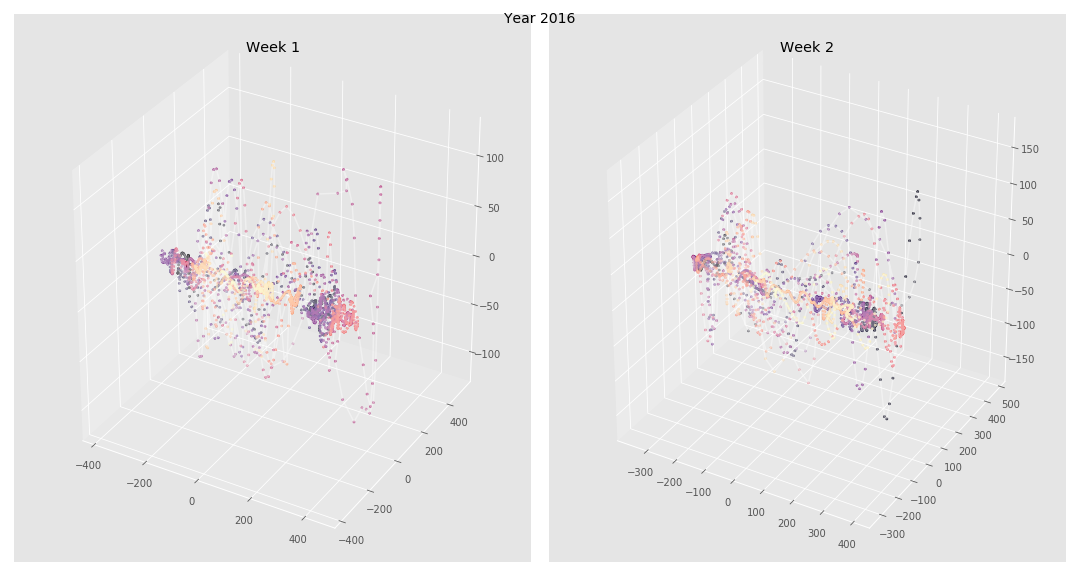

In [32]:
plt.figure(figsize=(15, 8))

for i, (Y, order, label) in enumerate(zip([XX1, XX2], 
                                   [order_x1, order_x2],
                                   ["Week 1", "Week 2"]
                                  ), 1):
    
    ax = plt.subplot(1, 2, i, projection="3d")    
    
    ax.plot3D(Y[:, 0], Y[:, 1], Y[:, 2], 'white', alpha=0.4)    
    
    ax.scatter3D(Y[:, 0], Y[:, 1], Y[:, 2], 
                 marker='.', #alpha=1,
                 c=order, 
                 cmap='magma',
                 label=label
                )
        
    ax.set_aspect('equal', 'datalim')
    ax.set_title(label)


plt.suptitle("Year 2016", fontsize=14)

plt.tight_layout()

<IPython.core.display.Javascript object>


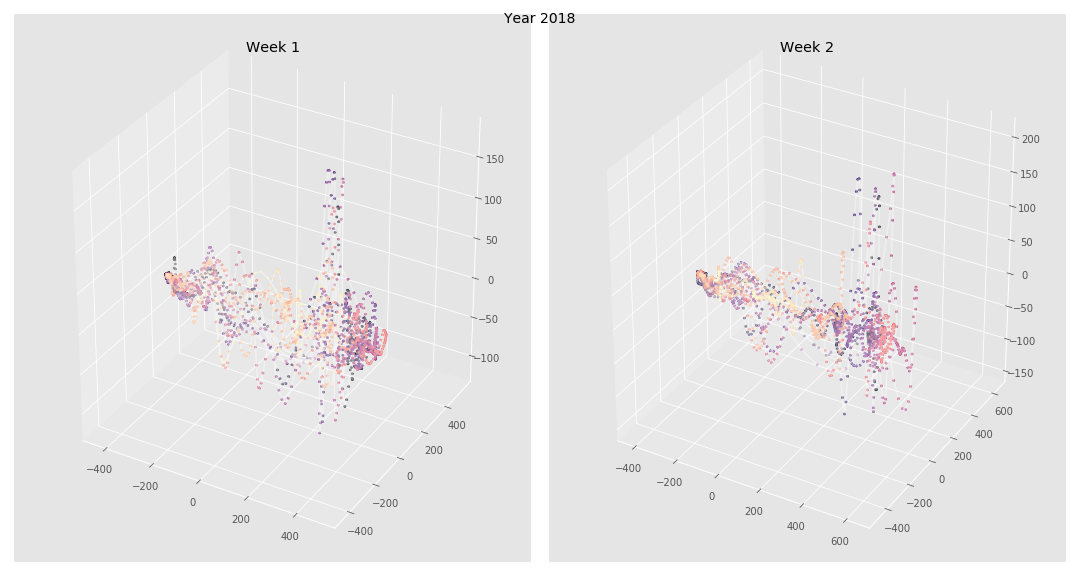

In [33]:
plt.figure(figsize=(15, 8))

step = 1
for i, (Y, order, label) in enumerate(zip([YY1, YY2], 
                                   [order_y1, order_y2],
                                   ["Week 1", "Week 2"]
                                  ), 1):
    
    ax = plt.subplot(1, 2, i, projection="3d")    
    
    ax.plot3D(Y[:, 0], Y[:, 1], Y[:, 2], 'white', alpha=0.4)    
    
    ax.scatter3D(Y[::step, 0], Y[::step, 1], Y[::step, 2], 
                 marker='.', # alpha=0.5,
                 c=order[::step], 
                 cmap='magma',
                 label=label
                )
        
    ax.set_aspect('equal', 'datalim')
    ax.set_title(label)


plt.suptitle("Year 2018", fontsize=14)

plt.tight_layout()

In [36]:
import ipyvolume as ipv

In [37]:
ipv.quickscatter(XX1[:, 0], XX1[:, 1], XX1[:, 2],
                 size=0.5, marker="sphere")

In [38]:
ipv.quickscatter(XX2[:, 0], XX2[:, 1], XX2[:, 2],
                 size=0.5, marker="sphere")

In [39]:
ipv.quickscatter(YY1[:, 0], YY1[:, 1], YY1[:, 2],
                 size=0.5, marker="sphere")

In [40]:
ipv.quickscatter(YY2[:, 0], YY2[:, 1], YY2[:, 2],
                 size=0.5, marker="sphere")

## TDA distance between descriptors

Compute persistent disgrams for sliding window embeddings.

Can compute on raw data or on PCA embeddings.

Consider using Witness complex or Alpha complex (on PCA embeddings).

Reduce number of points (maybe 2 to 3 days or resample time-series).

Consider using R version for TDA.

Tune $\tau, d, \delta_t$ for generating sliding window embeddings.

**TODO: Compare R-TDA bottleneck distance to Gudhi's bottleneck distance.**

In [41]:
def compute_persistence(X, max_edge_length=0.5, max_dim=1, complex_type="rips"):
    allowed_types = ("rips", "alpha", "witness")
    assert complex_type in allowed_types, "complex_type must be one of {}".format(("rips", "alpha", "witness"))
    
    if complex_type == "rips":
        sim_complex = gd.RipsComplex(points=X.tolist(), max_edge_length=max_edge_length)
        simplex_tree = sim_complex.create_simplex_tree(max_dimension=max_dim)
    elif complex_type == "alpha":
        sim_complex = gd.AlphaComplex(points=X.tolist())
        simplex_tree = sim_complex.create_simplex_tree()
        
    diag = simplex_tree.persistence()
    return sim_complex, simplex_tree, diag

In [42]:
max_dim = 2
max_edge_length = 0.5
complex_type = "alpha"

sim_complexX1, simtreeX1, diagX1 = compute_persistence(XX1, max_edge_length, max_dim, complex_type)
sim_complexX2, simtreeX2, diagX2 = compute_persistence(XX2, max_edge_length, max_dim, complex_type)
sim_complexY1, simtreeY1, diagY1 = compute_persistence(YY1, max_edge_length, max_dim, complex_type)
sim_complexY2, simtreeY2, diagY2 = compute_persistence(YY2, max_edge_length, max_dim, complex_type)

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

<module 'matplotlib.pyplot' from '/home/hongwei2/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

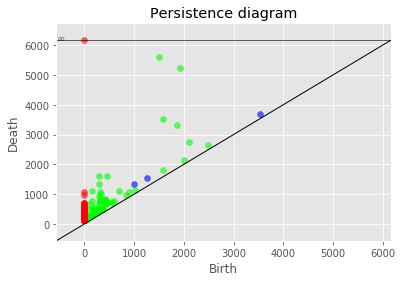

In [44]:
gd.plot_persistence_diagram(diagX1, max_plots=200)

<module 'matplotlib.pyplot' from '/home/hongwei2/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

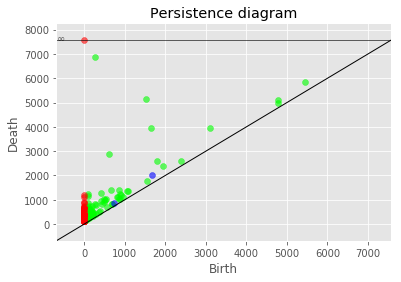

In [45]:
gd.plot_persistence_diagram(diagX2, max_plots=200)

<module 'matplotlib.pyplot' from '/home/hongwei2/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

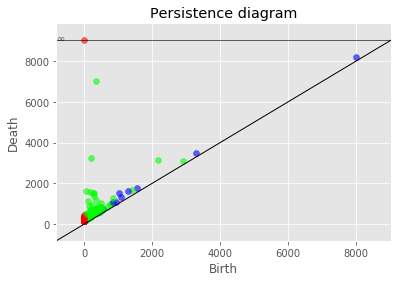

In [46]:
gd.plot_persistence_diagram(diagY1, max_plots=200)

<module 'matplotlib.pyplot' from '/home/hongwei2/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

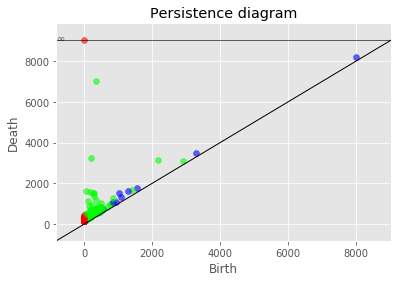

In [47]:
gd.plot_persistence_diagram(diagY1, max_plots=200)

## Visualize distances between weeks

In [ ]:
dim = 1
eta = 0.01
gd.bottleneck_distance(simtreeY2.persistence_intervals_in_dimension(dim),
                       simtreeX1.persistence_intervals_in_dimension(dim),
                       eta)

In [ ]:
dim = 0
eta = 0.01

X = (simtreeX1, simtreeX2, simtreeY1, simtreeY2)

N = len(X)
dist = np.zeros((N, N))

for i in range(N):
    simtree_i = X[i]    
    for j in range(i + 1, N):
        simtree_j = X[j]
        d = gd.bottleneck_distance(simtree_i.persistence_intervals_in_dimension(dim),
                                   simtree_j.persistence_intervals_in_dimension(dim),
                                   eta)
        dist[i, j] = d        

In [ ]:
plt.matshow(dist + dist.T, cmap=plt.cm.viridis)
plt.colorbar()

In [ ]:
dist + dist.T

In [ ]:
dim = 1
eta = 0.01

X = (simtreeX1, simtreeX2, simtreeY1, simtreeY2)

N = len(X)
dist = np.zeros((N, N))

for i in range(N):
    simtree_i = X[i]    
    for j in range(i + 1, N):
        simtree_j = X[j]
        d = gd.bottleneck_distance(simtree_i.persistence_intervals_in_dimension(dim),
                                   simtree_j.persistence_intervals_in_dimension(dim),
                                   eta)
        dist[i, j] = d        

In [ ]:
plt.matshow(dist + dist.T, cmap=plt.cm.viridis)
plt.colorbar()

In [ ]:
dist + dist.T

In [ ]:
dim = 2
eta = 0.01

X = (simtreeX1, simtreeX2, simtreeY1, simtreeY2)

N = len(X)
dist = np.zeros((N, N))

for i in range(N):
    simtree_i = X[i]    
    for j in range(i + 1, N):
        simtree_j = X[j]
        d = gd.bottleneck_distance(simtree_i.persistence_intervals_in_dimension(dim),
                                   simtree_j.persistence_intervals_in_dimension(dim),
                                   eta)
        dist[i, j] = d        

In [ ]:
plt.matshow(dist + dist.T, cmap=plt.cm.viridis)
plt.colorbar()

In [ ]:
dist + dist.T

## Perform statistical tests

In [ ]:
%matplotlib inline

In [ ]:
%matplotlib notebook

In [ ]:
import holoviews as hv

# hv.notebook_extension('bokeh', 'matplotlib')

hv.extension('matplotlib')
# hv.extension('bokeh')

---

# Miscellaneous code

Experiment with Plotly 3D interactive visualizations. This is faster than the Bokeh and Matplotlib-based visualizations at the cost of using much more memory as it uses WebGL to render the graphs locally whereas
Bokeh and Matplotlib are rendered on the server.

In [ ]:
import plotly as py
import plotly.graph_objs as go

import ipywidgets as widgets
from scipy import special

py.offline.init_notebook_mode(connected=True)

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [ ]:
import plotly

In [ ]:
def plot_3d_embeddings(*data, rgba=(217, 217, 217, 0.1), size=1, opacity=0.3, ncols=2):
    n_datasets = len(data)
    nrows = int(n_datasets / ncols + 0.5)
    
    traces = []
    rows = []
    cols = []
    for i, X in enumerate(data):
        r = i // ncols + 1
        c = i % ncols + 1
        
        rows.append(r)
        cols.append(c)
        trace = go.Scatter3d(x=X[:, 0], y=X[:, 1], z=X[:, 2],
                             mode='markers',
                             marker=dict(size=size, 
                                         line=dict(color='rgba({}, {}, {}, {})'.format(*rgba),
                                                   width=0.5),
                                         color="blue",
                                         opacity=opacity))
        traces.append(trace)
    
#     trace1 = go.Scatter3d(x=X[:, 0], y=X[:, 1], z=X[:, 2],
#                             mode='markers',
#                             marker=dict(
#                                 size=size,
#                                 line=dict(
#                                     color='rgba(217, 217, 217, 0.14)',
#                                     width=0.5
#                                 ),
#                                 opacity=opacity
#                             ))

#     layout = go.Layout(margin=dict(l=0, r=0, b=0, t=0))
#     fig = go.Figure(data=[trace1], layout=layout)
#     py.offline.iplot(fig, filename='simple-3d-scatter')
    
    specs = []
    for r in range(nrows):
        rspecs = []
        for c in range(ncols):
            rspecs.append({'is_3d': True})
        specs.append(rspecs)
        
    fig = tools.make_subplots(rows=nrows, 
                              cols=ncols, 
                              specs=specs,
                              horizontal_spacing=0.05)
    fig.add_traces(traces, rows, cols)
    margin = {
    "r": 10,
    "t": 25,
    "b": 40,
    "l": 60
    }
    fig.layout = go.Layout(margin=margin, height=600, width=600)
    
#     fig = go.Figure(rows=nrows, cols=ncols, data=traces, layout=layout)
    py.offline.iplot(fig, filename='simple-3d-scatter')

In [ ]:
plot_3d_embeddings(XX1, XX2, YY1, YY2)

---

In [ ]:
grouper = df2.loc[:, features].groupby([df2.index.week])
keys = list(grouper.groups.keys())
g = grouper.get_group(keys[1])

In [ ]:
len(keys)

In [ ]:
td = (g.index.max() - g.index.min())

In [ ]:
td.days

In [ ]:
grouper.get_group(keys[1])

In [ ]:
len(keys)